# Simple mining of your incoming/outgoing emails

This simple is example is prepared by [Qingkai Kong](https://github.com/qingkaikong/) (qingkai.kong@gmail.com) from [Berkeley Seismological Lab](http://seismo.berkeley.edu/) for The Hacker Within at BIDS on March 30th 2016. To run the script, you need the following dependencies:
1. matplotlib
2. pandas
3. numpy
4. scipy
5. pymc 
6. seaborn (optional, just uncomment the import command, and don't make some of the plots )

> The purpose of this script is to provide a working exmaple to show how we can use some simple tools to gain insight from daily stuff around us. I hope you will enjoy the script, and you are welcome to adding new stuff to this script as well!

In [1]:
%matplotlib inline

from imaplib import IMAP4_SSL
from datetime import date,timedelta,datetime
from time import mktime
from email.utils import parsedate
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dt
import pandas as pd
from matplotlib.dates import DateFormatter
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
import numpy as np

## 1 Getting email headers (only timestamp)

> This session, we will use the imaplib from python to grab the data from your gmail account inbox and sent box, and save the time of receiving/sending emails in a pandas dataframe

In [2]:
def getHeaders(address,password,folder):
    '''
    Function to get the email header data with only read emails. 
    '''
    
    # imap connection
    mail = IMAP4_SSL('imap.gmail.com')
    
    # login
    mail.login(address,password)
    
    # select the folder we want to anlyize 
    mail.select(folder) 
    
    # retrieving the uids
    result, data = mail.uid('search', None, 'SEEN')
    
    # you can also select the emails by using other filters, i.e. by time, by from etc
    # checkout the internet message protcol here:
    # http://tools.ietf.org/html/rfc3501.html
    ####### But be careful here!!! ########
    # if I use sentsince, which select emails from today to a past date, 
    # then all the unread emails before today will become read. 
    # so if you have many unread emails, you need be careful of using the time
    #interval = (datetime(2016,1,1) - timedelta(n_days)).strftime("%d-%b-%Y")
    #result, data = mail.uid('search', None, '(SENTSINCE {date})'.format(date=interval))
    
    # retrieving the headers
    result, data = mail.uid('fetch', data[0].replace(' ',','), 
                         '(BODY[HEADER.FIELDS (DATE)])')
    mail.close()
    mail.logout()
    return data

def headers2df(headers):
    '''
    Function to convert the header data from the gmails to pandas dataframe
    '''
    t = []
    for h in headers: 
        if len(h) > 1:
            try:
                timestamp = mktime(parsedate(h[1][5:].replace('.',':')))
            except:
                continue
            mailstamp = datetime.fromtimestamp(timestamp)
            t.append([mailstamp, 1])
       
    df = pd.DataFrame(t, columns=['Datetime', 'Count'])
    df = df.set_index('Datetime')
    return df

In [3]:
# get the header information (Only the time now)
mail_in = getHeaders(username,passwd,'inbox')
mail_out = getHeaders(username,passwd,'[Gmail]/Sent Mail')

# parse the data to pandas dataframe
df_in = headers2df(mail_in)
df_out = headers2df(mail_out)

In [4]:
# Just some simple numbers to show how much time you spent on emails! A lot!!!
num_out = len(df_out)
num_in = len(df_in)
print 'You sent %d emails since you joined Gmail, and it is about %.2f hours (%d days) if each one took you 5 min.' \
    %(num_out, num_out * 5.0 / 60., num_out* 5.0 / 60./24) 
print 'You received %d emails since you joined Gmail, and it is about %.2f hours (%d days) if each one took you 2 min.'\
    %(num_in, num_in * 5.0 / 60., num_in* 2.0 / 60./24) 

You sent 9720 emails since you joined Gmail, and it is about 810.00 hours (33 days) if each one took you 5 min.
You received 33001 emails since you joined Gmail, and it is about 2750.08 hours (45 days) if each one took you 2 min.


## 2 Distribution of emails during the day

> Let's first visualize your emails distribution within one day, we will plot a histogram of the number of emails you received and sent

In [5]:
def plot_hist_24hour(occurance_list, ylabel = None):
    '''
    Function to plot the histogram of the emails of the day
    '''
    
    hour_list = [t.hour for t in occurance_list]
    numbers=[x for x in xrange(0,24)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(0,23)
    plt.hist(hour_list, bins = 23)
    plt.xlabel('Hour', fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.show()

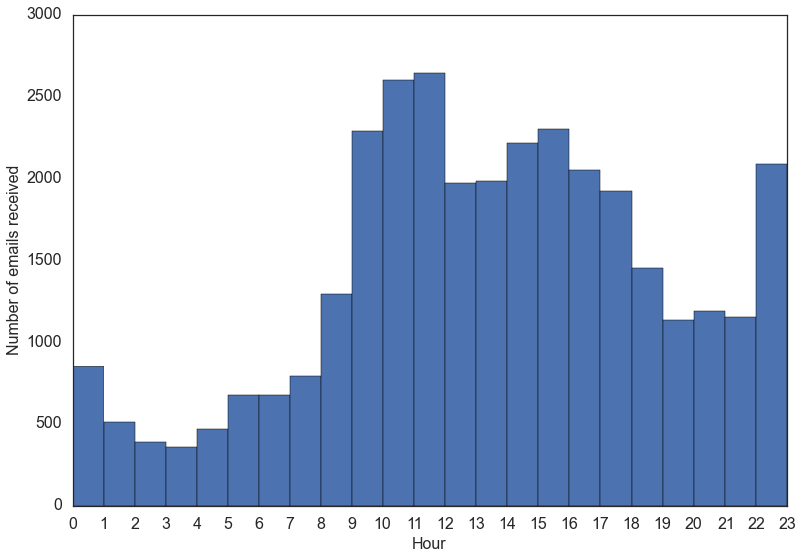

In [6]:
plot_hist_24hour(df_in.index, ylabel = 'Number of emails received')

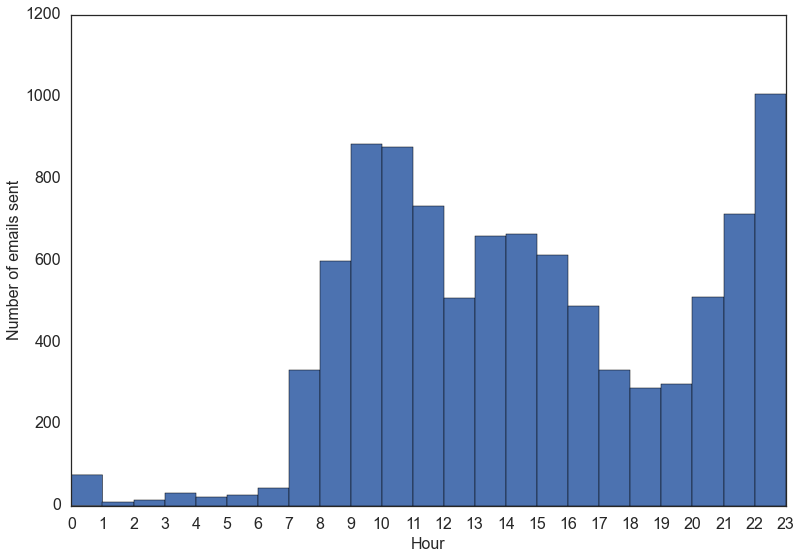

In [7]:
plot_hist_24hour(df_out.index, ylabel = 'Number of emails sent')

## 3 Emails through out time

> We want to see how our emails sent/received in the past years, and whether there are something we can notice as patterns. 

In [8]:
def plot_emails_overtime(df, title):
    '''
    Function to plot a scatter plot of the emails sent overtime.
    '''
    
    # get an array of the timestamp of the emails, and the hours across each day, you notice that 
    # for the y axis, we only need the hour, minute, second, so the date can be anything, I just
    # use 2016, 1, 1
    t_arr_sent = np.array([[t, datetime(2016,1,1, t.hour, t.minute, t.second)] for t in df.index])
    plt.figure(figsize = (16, 10))
    plt.plot_date(t_arr_sent[:, 0],t_arr_sent[:, 1],'.',alpha=.7)
    plt.xlabel('Date')
    plt.ylabel('Time')
    plt.title(title)
    plt.show()

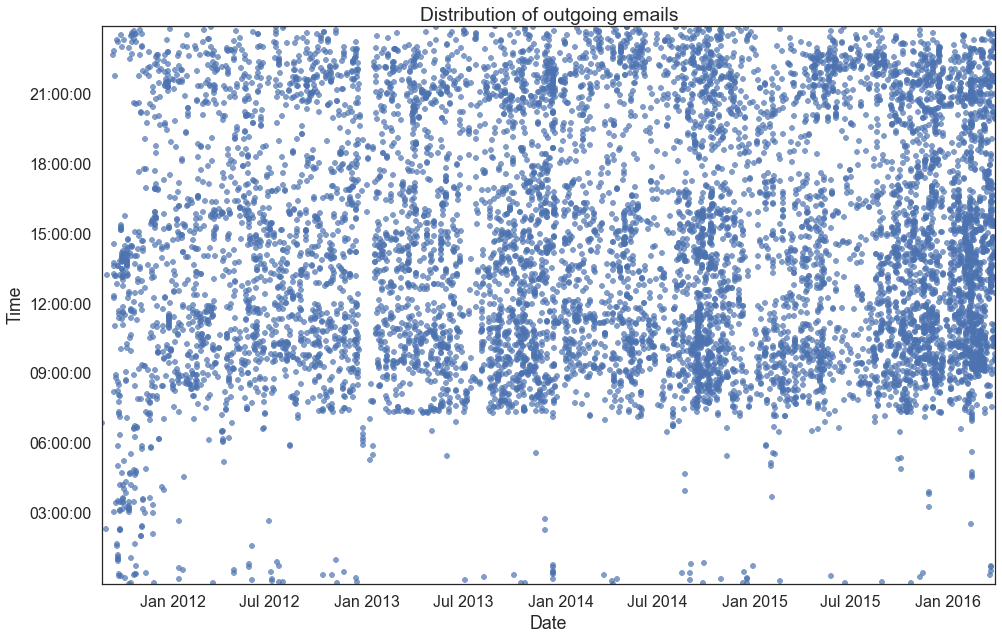

In [9]:
plot_emails_overtime(df_out, title = 'Distribution of outgoing emails')

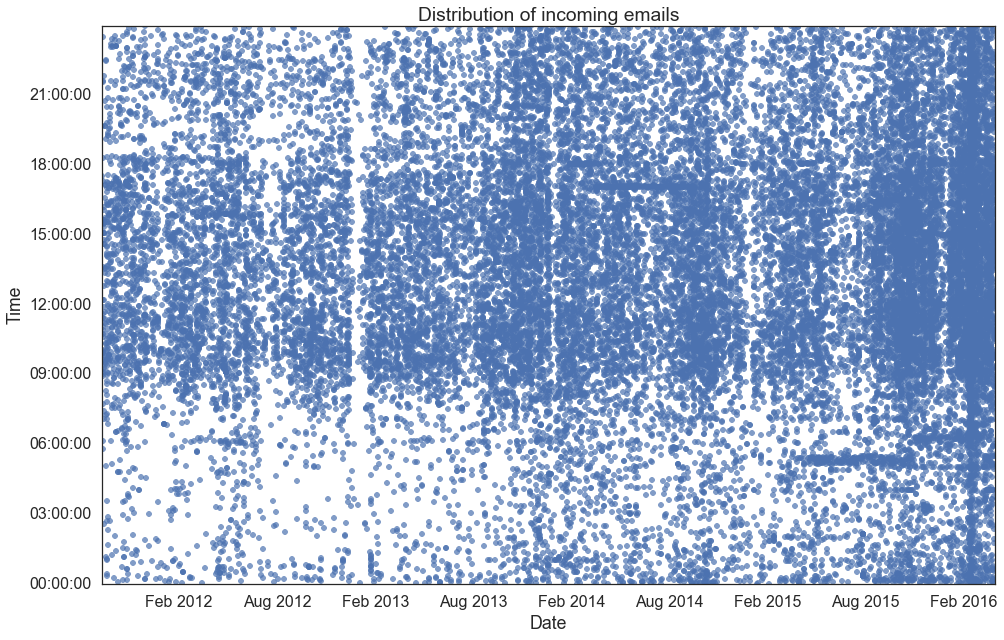

In [10]:
plot_emails_overtime(df_in, title = 'Distribution of incoming emails')

## 4 Slice the data from 2012 - 2016

> From the above figure, you saw that, before 2012, there are some issues with my clock on my old PC, which used Chinese time even when I arrived at US. So here, I will just slice the data for 2012 - 2016 to analyze. 

In [11]:
def slice_data(df, t0, t1):
    '''
    Function to slice the dataframe based on starttime t0, and endtime t1
    '''
    d0 = pd.Timestamp(t0).strftime('%Y-%m-%d %H:%M:%S')
    d1 = pd.Timestamp(t1).strftime('%Y-%m-%d %H:%M:%S')
    return df.ix[d0:d1]

In [12]:
# slice the data
t0 = '2012-01-01 00:00:00'
t1 = '2016-01-01 00:00:00'

df_in_sliced = slice_data(df_in, t0, t1)
df_out_sliced = slice_data(df_out, t0, t1)


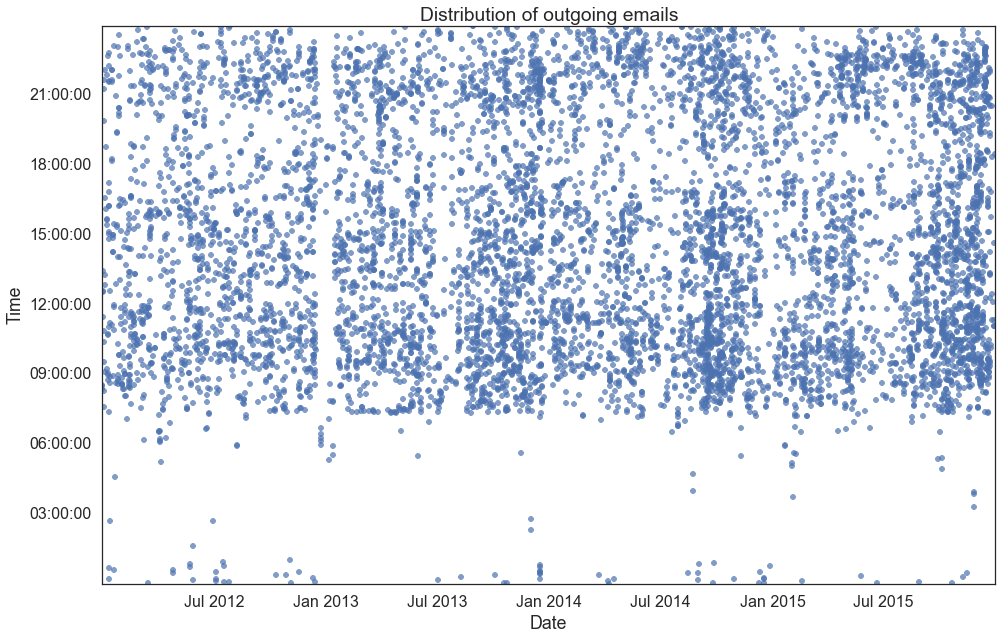

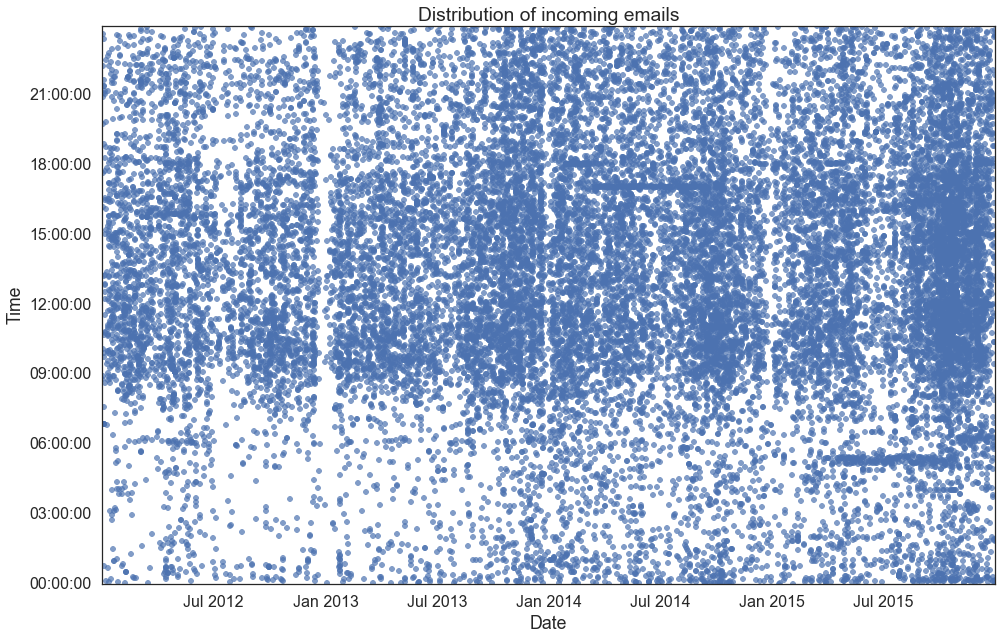

In [13]:
# reploting the emails scatter plot again
plot_emails_overtime(df_out_sliced, title = 'Distribution of outgoing emails')
plot_emails_overtime(df_in_sliced, title = 'Distribution of incoming emails')

## 5 Aggregate the emails based on a time interval

> Often when we analyze the time series data, one trick we usually do is to aggregate the data based on a time interval, the larger the interval is, the more smooth data you will get, so this aggragation is more like a low pass filter. 

In [14]:
# aggregate daily
daily_count_in = df_in_sliced.resample('D', how = 'count')
daily_count_out = df_out_sliced.resample('D', how = 'count')

# aggregate monthly
monthly_count_in = df_in_sliced.resample('M', how = 'count', label = 'Incoming')
monthly_count_out = df_out_sliced.resample('M', how = 'count', label = 'Outgoing')

In [15]:
def plot_aggregate_emails(x1, y1, x2, y2, title):
    '''
    Function to plot the aggregated results of the incoming and outgoing emails as a line chart
    '''
    
    plt.plot_date(x1, y1, '-', label = 'Incoming')
    plt.plot_date(x2, y2, '-', label = 'Outgoing')
    plt.xlabel('Date')
    plt.ylabel('Number of emails')
    plt.title(title)
    plt.legend(loc = 2)
    plt.show()

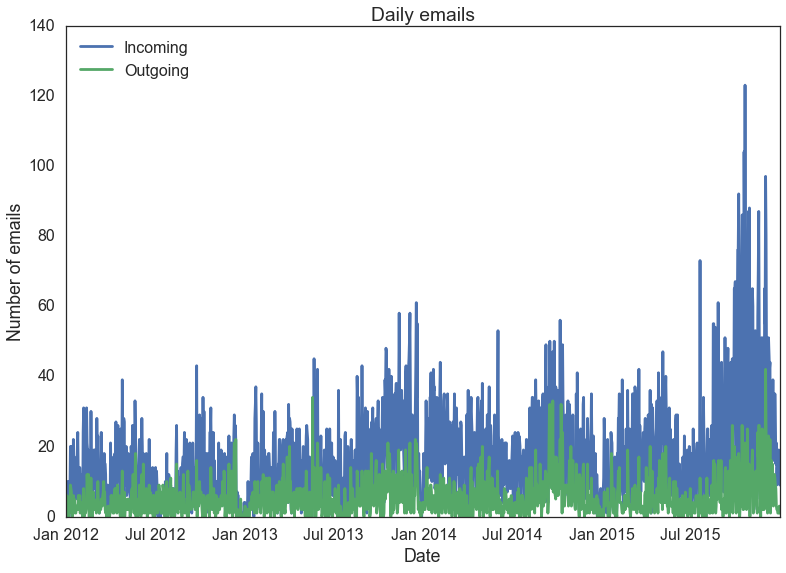

In [16]:
# You can see the general trend of the two curves are matching quite well, which means they are correlated with each
# other, of course, generally speaking, the more emails I got, the more I replied. Also, note the higher frequency 
# changes of the data
plot_aggregate_emails(daily_count_in.index, daily_count_in.Count, \
                      daily_count_out.index, daily_count_out.Count, 'Daily emails')

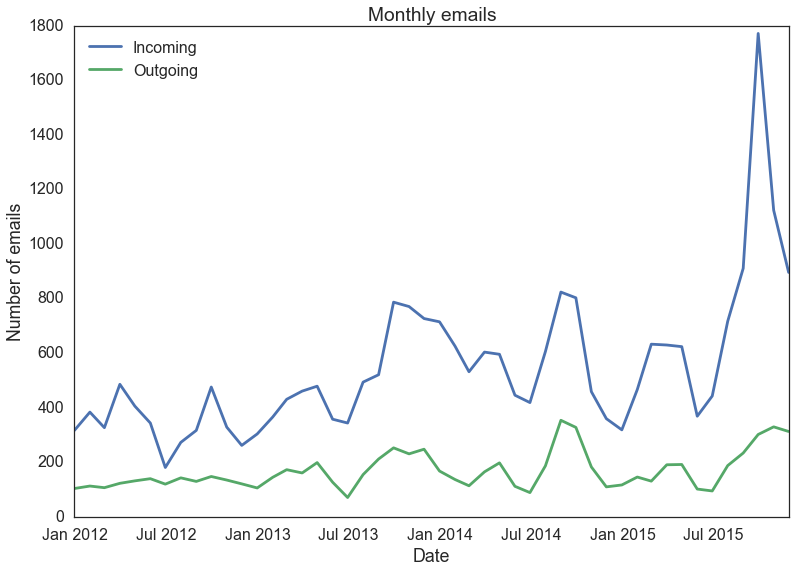

In [17]:
# Plotting the monthly data, and it is much smoother, and also shows the overview of the trend clearer! We ignore the
# details, but we got more large scale features. 
plot_aggregate_emails(monthly_count_in.index, monthly_count_in.Count, \
                      monthly_count_out.index, monthly_count_out.Count, 'Monthly emails')

### 5.1 Regression

> As we see above that there's a trend in the incoming/outgoing emails, let's just get an sense, how they change with each othe by using a simple regression. 

In [18]:
from scipy import stats

let's first plot the scatter plot between the monthly incoming/outgoing emails, and we can clearly see a strong correlation of the incoming and outgoing number of emails in the following figure. 

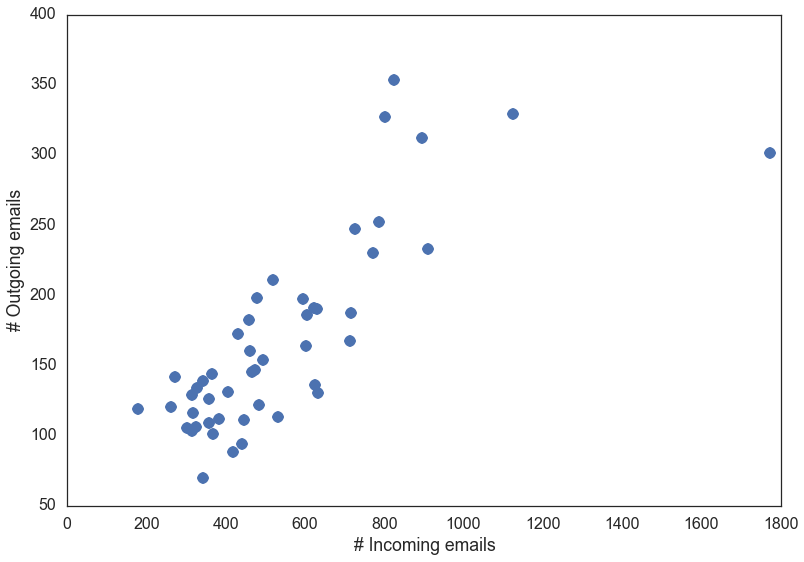

In [19]:
plt.plot(monthly_count_in.Count, monthly_count_out.Count, 'o')
plt.xlabel('# Incoming emails')
plt.ylabel('# Outgoing emails')
plt.show()

In [20]:
# a simple least square regression will show us the quantative relationship between the two
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(monthly_count_in.Count.values,monthly_count_out.Count.values)
print r_value, p_value, std_err, slope, intercept

0.786622200499 3.42142238444e-11 0.0232376539518 0.200792004774 58.6669627482


let's plot the regression model, we got the slope is 0.2, and the intercept is 58.7. 

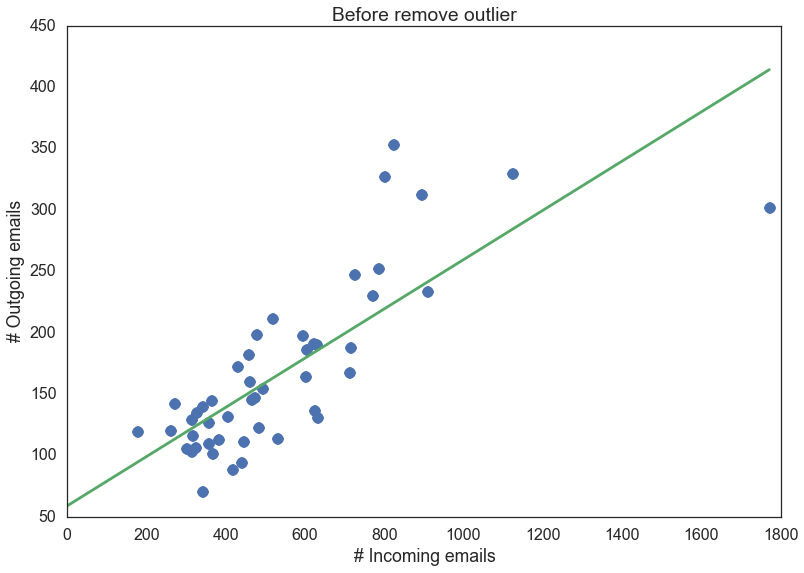

In [21]:
f  = lambda x: slope * x + intercept
x_grid = xrange(np.max(monthly_count_in.Count.values))
plt.plot(monthly_count_in.Count, monthly_count_out.Count, 'o')
plt.xlabel('# Incoming emails')
plt.ylabel('# Outgoing emails')
plt.plot(x_grid, map(f, x_grid), '-')
plt.title('Before remove outlier')
plt.show()

we clearly see there's an outlier in the data, and removing it will make the model more reasonable (or instead of using L2 norm, you can use L1 norm to reduce the effect of the outliers during regiression), but for this simple tutorial, we will manually remove the outlier.let's remove the outlier, and re-do the analysis. 

0.837629986414 2.12916047233e-13 0.0268947823285 0.276658844582 21.9797047953


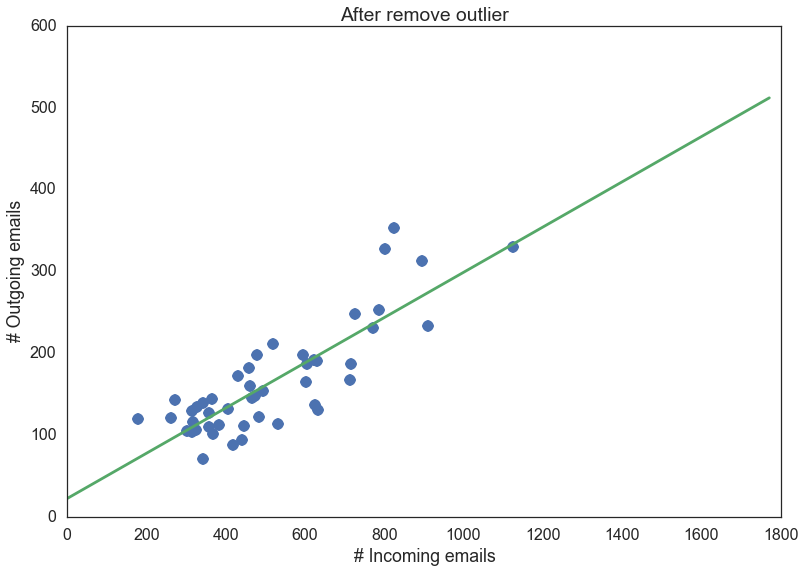

In [22]:
# we use very simple method to remove it, since it has a large number. 

# get the index of the non-outliers
ix = monthly_count_in.Count.values < 1500

# redo the regression
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(monthly_count_in.Count.values[ix],monthly_count_out.Count.values[ix])
print r_value, p_value, std_err, slope, intercept

# plot
f  = lambda x: slope * x + intercept
x_grid = xrange(np.max(monthly_count_in.Count.values))
plt.plot(monthly_count_in.Count[ix], monthly_count_out.Count[ix], 'o')
plt.xlabel('# Incoming emails')
plt.ylabel('# Outgoing emails')
plt.plot(x_grid, map(f, x_grid), '-')
plt.title('After remove outlier')
plt.show()

# This is simplely saying that I have a reply email rate 27.6%, less than 1/3. 

### 5.2 Some fun plots

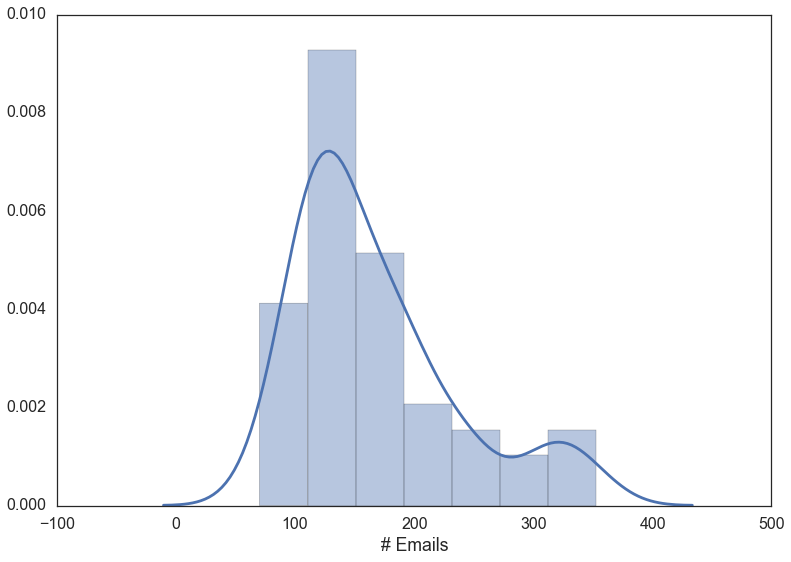

In [23]:
# plot the histogram and kernel density estimation of the monthly outgoing emails
sns.distplot(monthly_count_out)
plt.xlabel('# Emails')
plt.show()

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


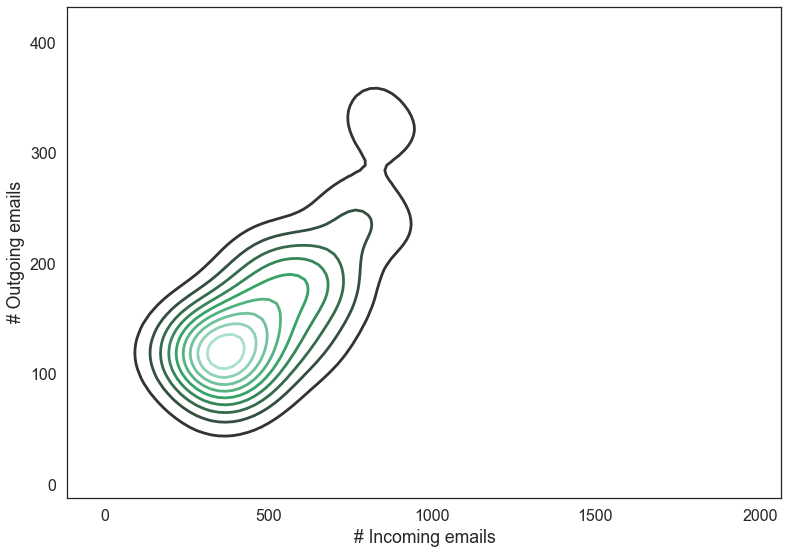

In [24]:
# plot the kernel density estimation of the incoming and outgoing emails
sns.kdeplot(monthly_count_in.Count, monthly_count_out.Count)
plt.xlabel('# Incoming emails')
plt.ylabel('# Outgoing emails')
plt.show()

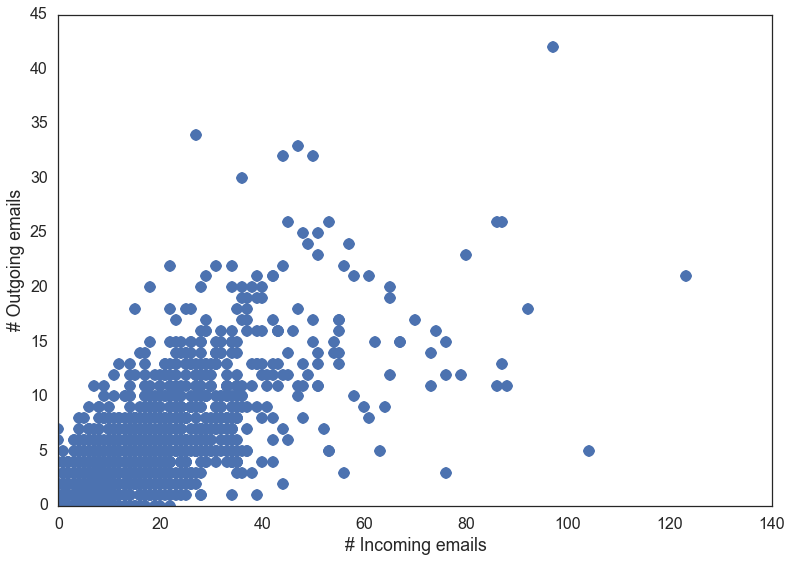

In [25]:
# this is just a scatter plot of the daily incoming and outgoing emails
plt.plot(daily_count_in.Count, daily_count_out.Count, 'o')
plt.xlabel('# Incoming emails')
plt.ylabel('# Outgoing emails')
plt.show()

/Library/Python/2.7/site-packages/seaborn/categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


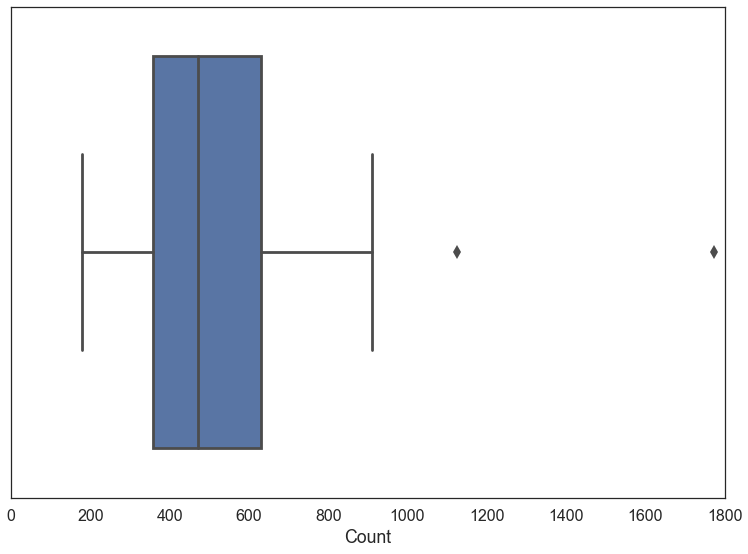

In [26]:
# a box plot to show the distribution of the incoming and outgoing emails. Also it is a good way to find out outliers
# by just look at the points outside of the whiskers points. 
ax = sns.boxplot(monthly_count_in.Count, names = ['Incoming'], \
                 fliersize = 10)
plt.show()

## 6 Did I have a repeating pattern of sending/receiving emails?

> In this section, we are trying to find out if I have some repeating emails sending/receiving pattern. I use the aggregated daily data, and do a FFT to transform this signal into frequency domain (note that since my sampling rate is 1 day, so the frequency is 1/day). The following figure shows you the top 5 peaks in the FFT spectrum, which are: 7 days, 182.6 days, 365 days, 243.5 days, and 3.5 days. Which makes sense, every week (7 days), my sent emails pattern repeat ^)^ Every half year, full year, 2/3 year (I think this is related with I am a student), half week (For all my semesters, Wed is always the quietest day), it repeat as well. Slightly different for the incoming emails, but overall it is the same. 

6.99043062201
182.625
365.25
243.5
3.5035971223


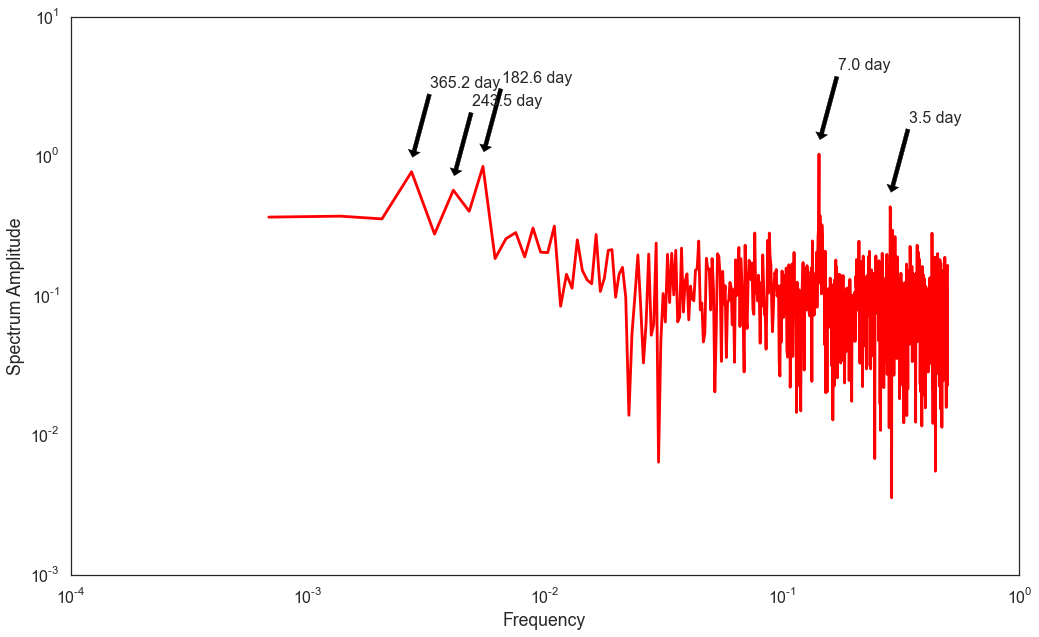

In [27]:
from scipy import fft

def plotSpectrum(y,Fs):
    """
    Function to plot the fft amplitude with the top 5 peaks
    """
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n/2)] # one side frequency range

    Y = fft(y)/n # fft computing and normalization
    Y = Y[range(n/2)]
    
    plt.figure(figsize = (17, 10))
    # find the top 5 amplitude, and there frequency
    for amp_arg in np.argsort(np.abs(Y))[::-1][1:6]:
        day = 1 / frq[amp_arg]
        amplitude = np.abs(Y[amp_arg])
        print 1 / frq[amp_arg]
        plt.annotate('%.1f day' %(day), xy=(frq[amp_arg], amplitude * 1.2), xytext=(frq[amp_arg] * 1.2, amplitude * 4),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 16)

    plt.plot(frq,np.abs(Y),'r') # plotting the spectrum
    plt.loglog()
    plt.xlabel('Frequency') # note here I use day as unit, so the frequency here is 1/day

    plt.ylabel('Spectrum Amplitude')
    

Fs = 1.;  # sampling rate (I use one day)
Ts = 1.0/Fs; # sampling interval
y = daily_count_out.Count.values

plotSpectrum(y,Fs)
plt.show()

## 7 Do I have a switchpoint point? 

In this session, we will use Bayesian method to find out a turning point that the user's sending email behavior changes. This example is based on the example in [Probabilistic Programming and Bayesian Method for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/). 

>  Look at the figure below, and it shows the monthly emails sent by me. The question we want to ask is: If the user's sending email behavior changes with time. If it is, are there a switchpoint that separate the different behavior? Can you guess a change point from the figure?


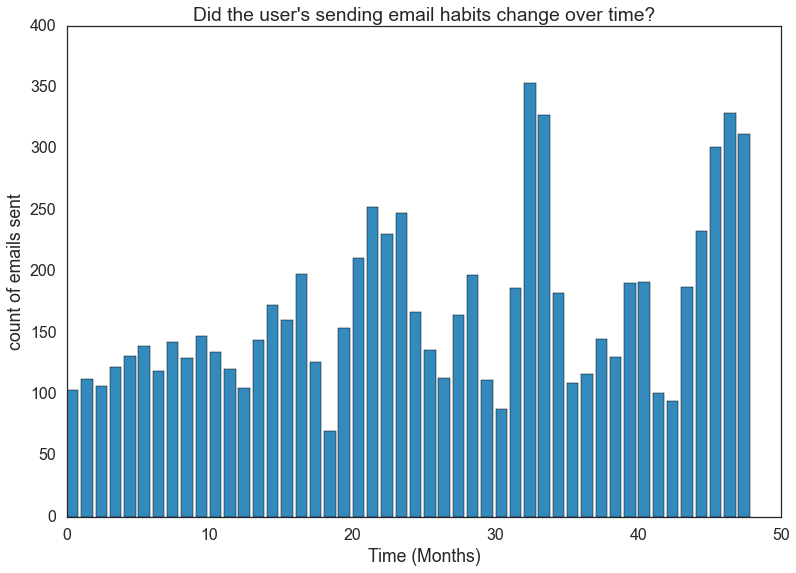

In [28]:
count_data = monthly_count_out.Count
date = monthly_count_out.index
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (Months)")
plt.ylabel("count of emails sent")
plt.title("Did the user's sending email habits change over time?")
plt.show()

Now let's start modeling the problem. A Poisson distribution is usually used to model the *count* data. Denoting month $i$'s outgoing emails count by $C_i$, 

$$ C_i \sim \text{Poisson}(\lambda)  $$

$$P(C = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots $$

So we have no idea right now what is the value of the $\lambda$ parameter really is, however. Looking at the chart above, we know that the number of emails sent is growing, and have a higher rate in the later period, which is equivalent to saying that $\lambda$ increases at some point during the observations. (The higher value of $\lambda$ , the higher probability of many emails sent by a user in a given month.)

Let's assume that on some month during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value (this is the turning point). Then we will have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *switchpoint*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? $\lambda$ can be any positive number. The *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. Since the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice.  A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 

What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible month. This is equivalent to saying

\begin{align}
& \tau \sim \text{DiscreteUniform(1,40) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{40}
\end{align}

So after all this, what does our overall prior distribution for the unknown variables look like? Frankly, *it doesn't matter*. What we should understand is that it's an ugly, complicated mess involving symbols only a mathematician could love. And things will only get uglier the more complicated our models become. Regardless, all we really care about is the posterior distribution.

We will use PyMC (a Python library for programming Bayesian analysis) to model and solve the problem. 

In [29]:
import pymc as pm

alpha = 1.0 / count_data.mean()  # Recall count_data is the
                               # variable that holds our outgoing email counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [30]:
# define lambda
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

In [31]:
# Let's build the model
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

# Mysterious code to be explained in Chapter 3.
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

# Get the sampled distribution for each parameter
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 5.5 sec

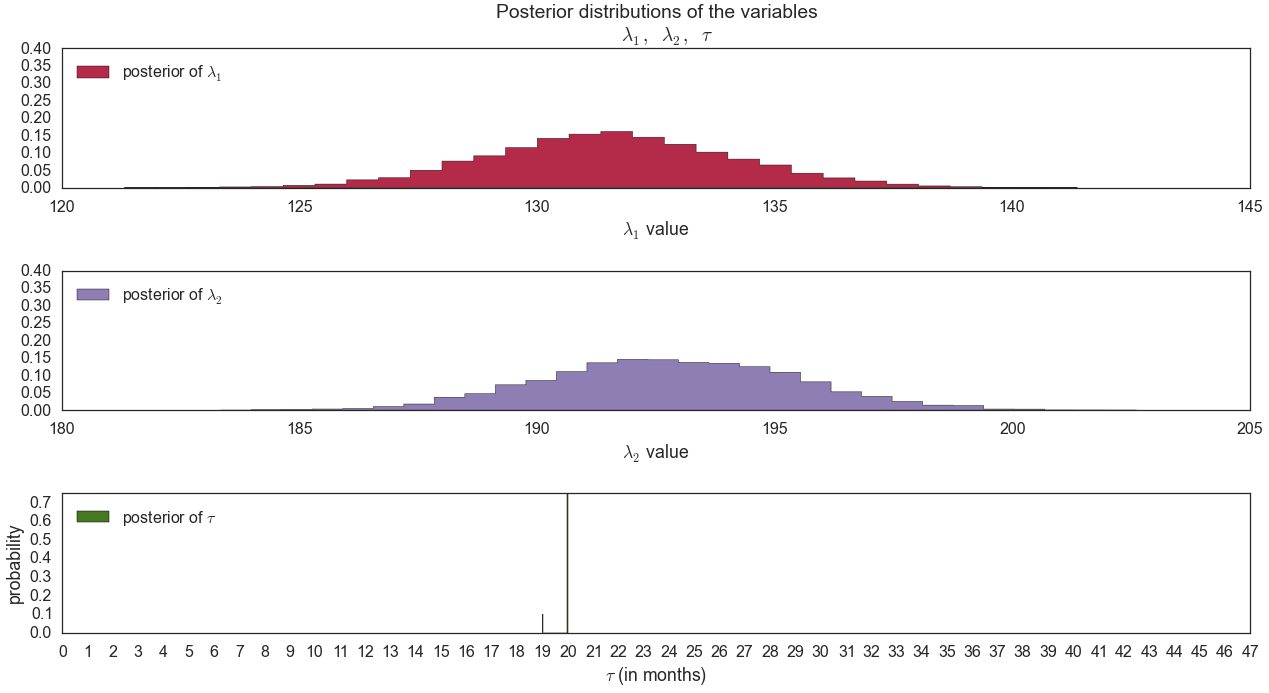

In [32]:
# Plot the distribution of the different parameters
plt.figure(figsize = (18, 10))
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.ylim([0, 0.4])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.ylim([0, 0.4])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
#plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in months)")
plt.ylabel("probability");
plt.tight_layout()
plt.show()

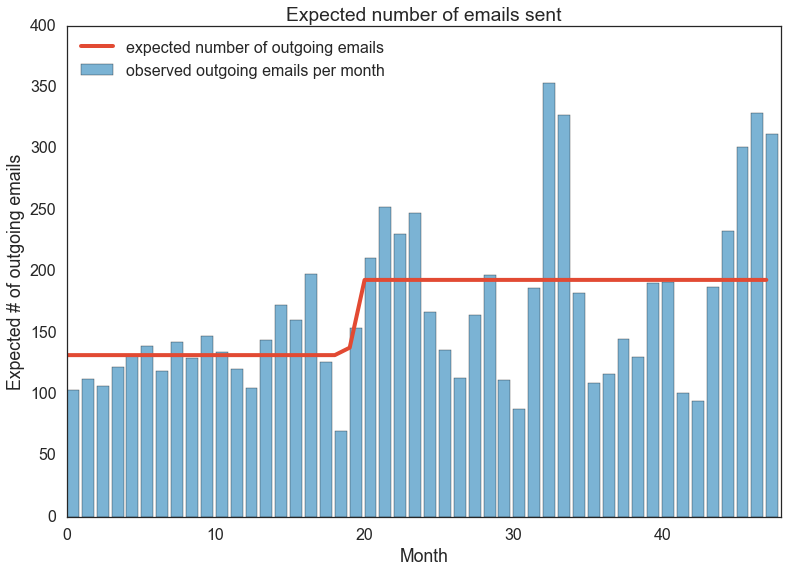

In [33]:
# 
N = tau_samples.shape[0]
expected_emails_per_month = np.zeros(n_count_data)
for month in range(0, n_count_data):
    
    # get the index of months before the swtichpoint
    ix = month < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each month, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "emials count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "emails count".
    expected_emails_per_month[month] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_emails_per_month, lw=4, color="#E24A33",
         label="expected number of outgoing emails")
plt.xlim(0, n_count_data)
plt.xlabel("Month")
plt.ylabel("Expected # of outgoing emails")
plt.title("Expected number of emails sent")
#plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed outgoing emails per month")

plt.legend(loc=2);
plt.show()